# 匀速运动退化图像的复原

## 匀速运动参数的估计

常用的图像复原方法有逆滤波、维纳滤波、约束最小二乘方滤波、几何均值滤波，应用这些滤波法之前都需要先知道运动模糊的传递函数 $H(u, v)$，因此对运动参数的估计是滤波前必须完成的工作。在构造匀速运动退化滤波器时，我们引入的参数包括曝光时间 $T$、沿 $x$ 方向的移动量 $a$，沿 $y$ 方向的移动量 $b$。通常在拿到一幅照片时曝光时间是已知的，而移动量则是未知的，因此我们需要设法从图片中估计参数 $a, b$。

### 运动方向的估计

我们首先对一幅经理想退化滤波的图像和一幅实拍的退化图像，计算其频谱，观察运动模糊在频谱上的特征。

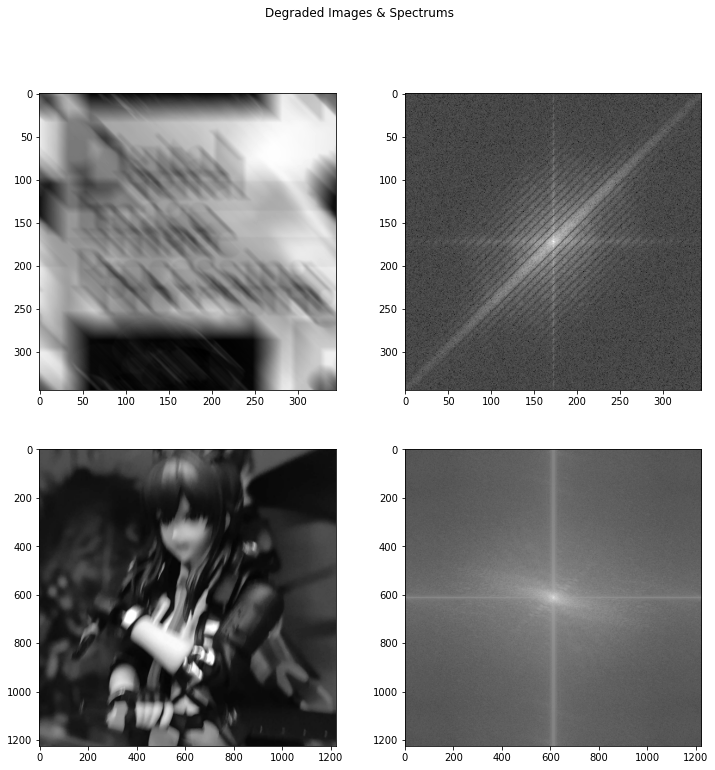

In [185]:
# 计算理想、实拍运动模糊图像的频谱
# 为了让频谱值更好被识别，显示之前对频谱取了对数
import matplotlib.pyplot as plt
import numpy as np

book_cover_filt = np.uint8(np.multiply(plt.imread('book_cover_filt.png'), 255))
book_cover_filt_fft = np.fft.fftshift(np.fft.fft2(book_cover_filt))

chen_figure_filt = plt.imread('chen_figure.jpg')
chen_figure_filt_fft = np.fft.fftshift(np.fft.fft2(chen_figure_filt))

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Degraded Images & Spectrums')
ax11.imshow(book_cover_filt, cmap='gray')
ax12.imshow(np.log(np.abs(book_cover_filt_fft)), cmap='gray')
ax21.imshow(chen_figure_filt, cmap='gray')
ax22.imshow(np.log(np.abs(chen_figure_filt_fft)), cmap='gray')

我们容易在频谱中发现，具有运动模糊特征的图像的频谱中，除集中包含图像本身信息的十字亮线外，还有一条较亮的斜线。这条斜线是由于运动模糊产生的，与退化滤波器的频谱图像相对应，故可以从斜线中采集到关于运动参数的信息。

仍然使用基本原理的建模方法，我们从退化传递函数下手，观察频谱与函数中参数的关系。

$$ H(u, v) = \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \mathrm{e}^{-\mathrm{j}\pi (ua+vb)} $$

由于我们对频谱取了模，上式可以写为模的形式

$$ |H(u, v)| = \left| \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \right| $$

我们取 $T = 1$，并将 $ua+vb$ 换成 $x$，绘制出 $|H(u, v)|$ 与 $x$ 关系的图像。

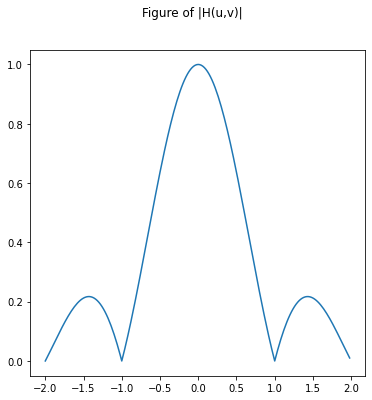

In [186]:
# 绘制|H(u,v)|的图像
T = 1

def evaluate_H_mod(x: float) -> float:
    if x == 0:
        return T
    return abs(T / (np.pi * x) * np.sin(np.pi * x))

x = [0 for i in range(200)]
H = [0 for i in range(200)]
x_step = 4 / 200
for i in range(200):
    x[i] = -2 + x_step * i
    H[i] = evaluate_H_mod(x[i])

fig, ax = plt.subplots(1, figsize=(6, 6))
fig.suptitle('Figure of |H(u,v)|')
ax.plot(x, H)

容易发现，这一函数在 $x=ua+vb=0$ 处取得最大值 $T$。因此，频谱中的斜线对应的就是 $ua+vb=0$ 直线，其斜率 $k=-\dfrac{b}{a}$ 可代表运动的方向。但频谱中无法提供关于运动距离的信息，我们仍然需要考虑使用其他方法。

### 运动距离的估计

通过观察，我们还可以发现，如果将图片沿运动方向平移，取图片的行相邻像素一阶差分（$f(x, y)-f(x-1, y)$），在恰好平移运动距离长度后一阶差分会出现自相关极小峰值。这是因为，在平移长度不超过运动距离时，图像中仍然有一部分因运动模糊产生的拖影重合；而长度等于运动距离时，重合恰好消失。我们可以利用这一原理估计运动的距离。

为了让实现更简单，我们先将图片旋转至运动方向与横坐标平行，再求一阶差分。以上面的图例进行测试，`book_cover_filt.jpg` 一图运动方向为 -45°，而 `chen_figma3.jpg` 一图约为 16°。

In [187]:
# 旋转图片至运动方向与横坐标方向平行，并求一阶差分
from typing import List
import scipy.ndimage as ndi

def rotate_and_diff(img: List[List], angle: float):
    img = ndi.rotate(img, angle)
    (n, m) = (len(img), len(img[0]))
    new_img = [[0 for _ in range(m)] for _ in range(n)]
    for i in range(n - 1, 0, -1):
        for j in range(m - 1, 0, -1):
            if i == 0:
                new_img[i][j] = int(img[i][j])
            else:
                new_img[i][j] = int(img[i][j]) - int(img[i - 1][j])
    return (img, new_img)

book_cover_r, book_cover_diff = rotate_and_diff(book_cover_filt.copy(), 45)
chen_figure_r, chen_figure_diff = rotate_and_diff(chen_figure_filt.copy(), -21)

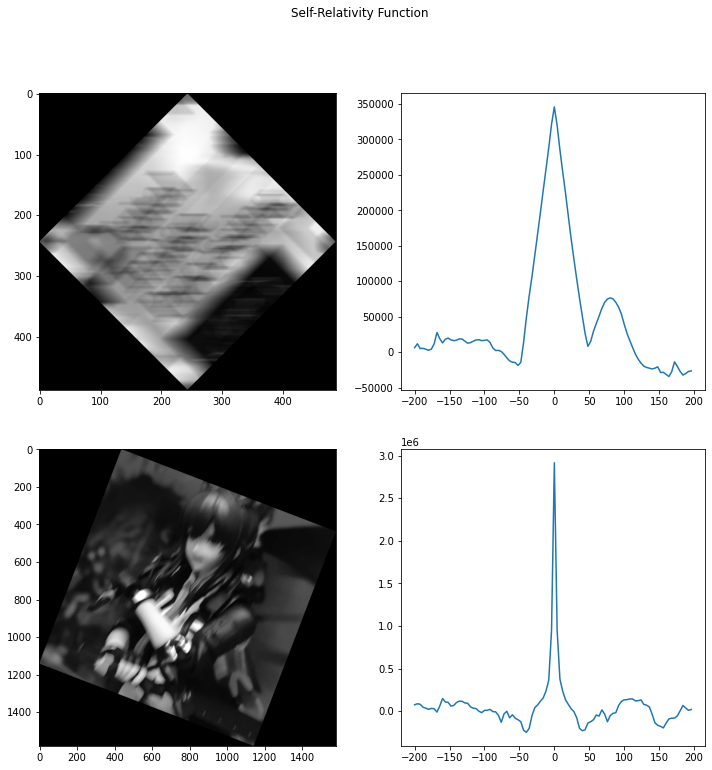

In [188]:
# 求出两幅图片的相关性函数
def get_relativity(img: List[List], shift: int) -> float:
    n, m = (len(img), len(img[0]))
    result = 0
    for i in range(n // 2 - n // 10, n // 2 + n // 10):
        for j in range(m // 2 - m // 10, m // 2 + m // 10):
            nj = ((j + shift) % m + m) % m
            result += int(img[i][j]) * int(img[i][nj])
    return result

n_sample = 100

x = [0 for _ in range(n_sample)]
R1 = [0 for _ in range(n_sample)]
R2 = [0 for _ in range(n_sample)]

for i in range(n_sample):
    x[i] = -n_sample * 2 + i * 4
    R1[i] = get_relativity(book_cover_diff, x[i])
    R2[i] = get_relativity(chen_figure_diff, x[i])

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Self-Relativity Function')

ax11.imshow(book_cover_r, cmap='gray')
ax12.plot(x, R1)
ax21.imshow(chen_figure_r, cmap='gray')
ax22.plot(x, R2)

上图中我们可以观察到，理想退化图像的极小值在 50 附近，而实拍退化图像的极小值在 40 附近。接下来，我们将利用这些信息分别对两幅图像进行复原。

## 匀速运动退化图像的复原

### 逆滤波法

我们在之前已经得到了运动模糊图像的退化滤波器传递函数，因此只需要在频域除掉这个滤波器，即可实现对滤波效果的恢复。

In [189]:
# 逆滤波法实现
from cmath import pi, sin, exp

EPS = 1e-06

def evaluate_H(T, a, b, u, v):
    if u * a + v * b == 0:
        return T
    return T / (pi * (u * a + v * b)) * sin(pi * (u * a + v * b)) * exp(-1j * pi * (u * a + v * b))

def inverse_filter(img, a, b, T, r):
    (n, m) = (len(img), len(img[0]))
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    new_img_fft = img_fft.copy()
    for i in range(n // 2 - r, n // 2 + r):
        for j in range(m // 2 - r, m // 2 + r):
            new_img_fft[i][j] /= evaluate_H(T, a, b, i - n // 2, j - m // 2)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(new_img_fft)))
    return img_fft, new_img_fft, new_img

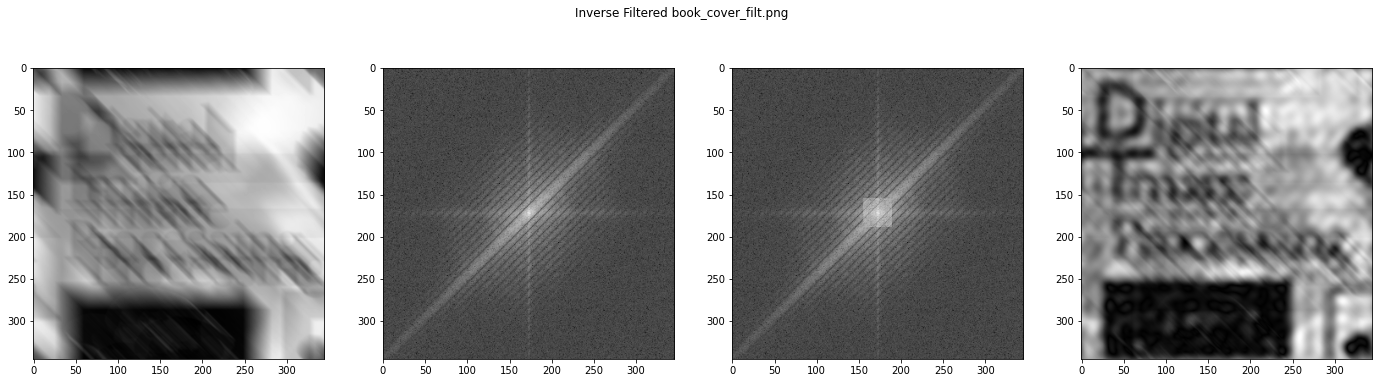

In [190]:
# book_cover_filt.png
(n, m) = (len(book_cover_filt), len(book_cover_filt[0]))
shift = 50
(x_shift, y_shift) = (-shift * np.sin(-np.pi / 4), shift * np.cos(-np.pi / 4))
book_fft, book_fft_new, book_new = inverse_filter(book_cover_filt, x_shift / n, y_shift / m, 1, 17)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Inverse Filtered book_cover_filt.png')
ax1.imshow(book_cover_filt, cmap='gray')
ax2.imshow(np.log(np.abs(book_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(book_fft_new)), cmap='gray')
ax4.imshow(book_new, cmap='gray')

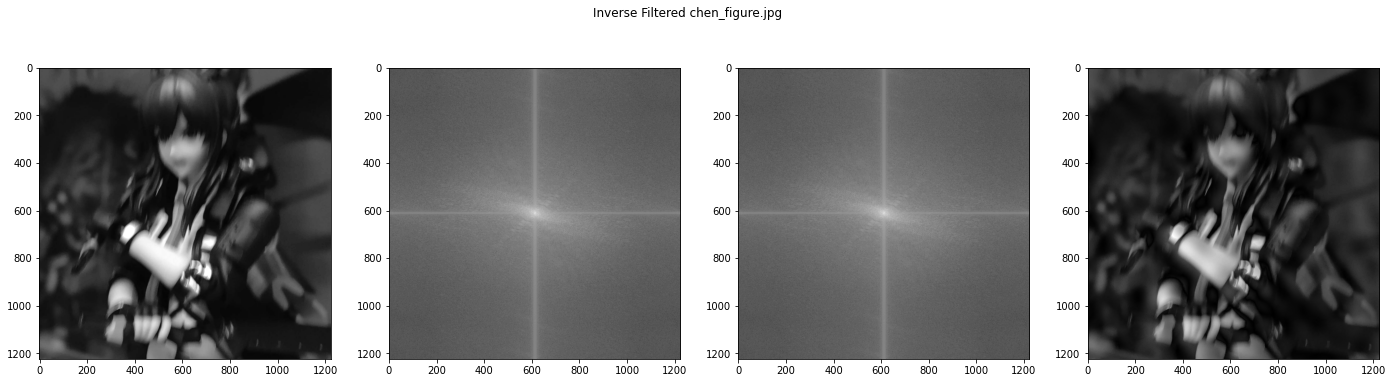

In [191]:
# chen_figure.jpg
(n, m) = (len(chen_figure_filt), len(chen_figure_filt[0]))
shift = 45
(x_shift, y_shift) = (-shift * np.sin(np.pi / 180 * 21), shift * np.cos(np.pi / 180 * 21))
chen_fft, chen_fft_new, chen_new = inverse_filter(chen_figure_filt, x_shift / n, y_shift / m, 1, 10)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Inverse Filtered chen_figure.jpg')
ax1.imshow(chen_figure_filt, cmap='gray')
ax2.imshow(np.log(np.abs(chen_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(chen_fft_new)), cmap='gray')
ax4.imshow(chen_new, cmap='gray')
chen_new = [[min(i, 255) for i in line] for line in chen_new]